In [32]:
# Install RDKit (Cheminformatics) and PyTorch Geometric (GNNs)
!pip install rdkit
!pip install torch_geometric
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import Data, DataLoader
from rdkit import Chem
from rdkit.Chem import Draw
import numpy as np
import matplotlib.pyplot as plt

print(" Libraries installed successfully.")

 Libraries installed successfully.


 Successfully loaded real dataset with 1128 molecules.
  Compound ID  ESOL predicted log solubility in mols per litre  \
0   Amigdalin                                           -0.974   
1    Fenfuram                                           -2.885   
2      citral                                           -2.579   
3      Picene                                           -6.618   
4   Thiophene                                           -2.232   

   Minimum Degree  Molecular Weight  Number of H-Bond Donors  Number of Rings  \
0               1           457.432                        7                3   
1               1           201.225                        1                2   
2               1           152.237                        0                0   
3               2           278.354                        0                5   
4               2            84.143                        0                1   

   Number of Rotatable Bonds  Polar Surface Area  \
0        

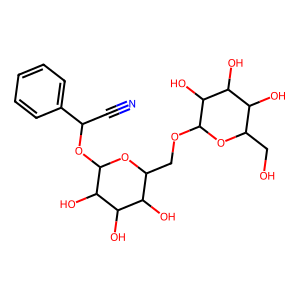

In [33]:
import pandas as pd
import io
import requests


url = "https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/delaney-processed.csv"
response = requests.get(url)
df = pd.read_csv(io.StringIO(response.content.decode('utf-8')))


print(f" Successfully loaded real dataset with {len(df)} molecules.")
print(df.head())


dataset_smiles = df['smiles'].tolist()
labels = df['measured log solubility in mols per litre'].tolist()


print(f"\nExample SMILES: {dataset_smiles[0]}")
mol = Chem.MolFromSmiles(dataset_smiles[0])
Draw.MolToImage(mol)

In [34]:
def smiles_to_graph(smiles, label):
    mol = Chem.MolFromSmiles(smiles)

    if mol is None: return None # Skip invalid molecules


    node_features = []
    for atom in mol.GetAtoms():
        node_features.append([atom.GetAtomicNum()])

    x = torch.tensor(node_features, dtype=torch.float)


    edge_indices = []
    for bond in mol.GetBonds():
        start = bond.GetBeginAtomIdx()
        end = bond.GetEndAtomIdx()

        edge_indices.append([start, end])
        edge_indices.append([end, start])

    if len(edge_indices) == 0:
        edge_index = torch.empty((2, 0), dtype=torch.long)
    else:
        edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()

    y = torch.tensor([label], dtype=torch.float)
    return Data(x=x, edge_index=edge_index, y=y)


print("Converting molecules to graphs... (This might take a moment)")
graph_data_list = []


for smiles, label in zip(dataset_smiles, labels):
    graph = smiles_to_graph(smiles, label)
    if graph:
        graph_data_list.append(graph)


from torch_geometric.loader import DataLoader
train_loader = DataLoader(graph_data_list, batch_size=64, shuffle=True)

print(f"✅ Success! Converted {len(graph_data_list)} molecules into Graph format.")
print(f"Example Node Features (First Molecule): \n{graph_data_list[0].x}")

Converting molecules to graphs... (This might take a moment)
✅ Success! Converted 1128 molecules into Graph format.
Example Node Features (First Molecule): 
tensor([[8.],
        [6.],
        [6.],
        [8.],
        [6.],
        [8.],
        [6.],
        [6.],
        [8.],
        [6.],
        [8.],
        [6.],
        [6.],
        [7.],
        [6.],
        [6.],
        [6.],
        [6.],
        [6.],
        [6.],
        [6.],
        [8.],
        [6.],
        [8.],
        [6.],
        [8.],
        [6.],
        [8.],
        [6.],
        [8.],
        [6.],
        [8.]])


In [35]:
class DrugInteractionGNN(torch.nn.Module):
    def __init__(self):
        super(DrugInteractionGNN, self).__init__()


        self.conv1 = GCNConv(in_channels=1, out_channels=64)


        self.conv2 = GCNConv(in_channels=64, out_channels=64)


        self.conv3 = GCNConv(in_channels=64, out_channels=64)


        self.fc = torch.nn.Linear(64, 1)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch


        x = self.conv1(x, edge_index)
        x = F.relu(x) # Activation function
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        x = F.relu(x)


        x = global_mean_pool(x, batch)


        x = self.fc(x)

        return x

# Initialize the model
model = DrugInteractionGNN()
print("✅ Model Architecture Created:")
print(model)

✅ Model Architecture Created:
DrugInteractionGNN(
  (conv1): GCNConv(1, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


In [31]:


optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = torch.nn.MSELoss()


print("Starting  Training...")
model.train()

for epoch in range(200):
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        output = model(batch)
        loss = criterion(output.view(-1), batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1} | Loss: {total_loss:.4f}")

print(" Training Complete!")

Starting  Training...
Epoch 20 | Loss: 57.8753
Epoch 40 | Loss: 57.5023
Epoch 60 | Loss: 57.2606
Epoch 80 | Loss: 56.5266
Epoch 100 | Loss: 57.6311
Epoch 120 | Loss: 58.9155
Epoch 140 | Loss: 56.0579
Epoch 160 | Loss: 58.0320
Epoch 180 | Loss: 55.3358
Epoch 200 | Loss: 55.7233
 Training Complete!


In [36]:

model.eval()

# Let's test on the first 5 molecules in our list
print(f"{'MOLECULE (SMILES)':<40} | {'REAL VALUE':<10} | {'PREDICTED':<10}")
print("-" * 70)

for i in range(5):
    data = graph_data_list[i]


    with torch.no_grad():
        pred = model(data)

    real_val = data.y.item()
    pred_val = pred.item()

    print(f"{dataset_smiles[i][:35]:<40} ... | {real_val:<10.2f} | {pred_val:<10.2f}")

MOLECULE (SMILES)                        | REAL VALUE | PREDICTED 
----------------------------------------------------------------------
OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C      ... | -0.77      | 0.18      
Cc1occc1C(=O)Nc2ccccc2                   ... | -3.30      | 0.17      
CC(C)=CCCC(C)=CC(=O)                     ... | -2.06      | 0.17      
c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43       ... | -7.87      | 0.16      
c1ccsc1                                  ... | -1.33      | 0.22      
